In [7]:
# Dataset: insert URL

import os 
path_to_dataset = "mushroom_dataset"
train_path = path_to_dataset +"/train"
test_path = path_to_dataset + "/test"
valid_path = path_to_dataset + "/valid"


no_of_classes = len(os.listdir(train_path))
print("No. of Classes: " + str(no_of_classes))


import matplotlib.pyplot as plt
import matplotlib.image as mping
import random

# view a random image
def view_random_image(target_dir, target_class) :
    target_folder = target_dir + "/" + target_class
    # get the random image
    random_image = random.sample(os.listdir(target_folder), 1)
    # show the image
    img = mping.imread(target_folder + "/" + random_image[0])
    plt.imshow(img)
    plt.title(target_class)
    plt.axis("off")
    plt.show()

    print(f"Image shape: {img.shape}")
    return img

img = view_random_image(target_dir=train_path, target_class='poisonous')


No. of Classes: 2


SyntaxError: not a PNG file (<string>)

In [8]:

# Build the model

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# rescale the image -> from 0-255 to 0-1
train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)
valid_datagen = ImageDataGenerator(rescale = 1./255)

train_data = train_datagen.flow_from_directory(directory=train_path,
                                               batch_size=32,
                                               target_size=(224,224),
                                               class_mode="categorical")

test_data = test_datagen.flow_from_directory(directory=test_path,
                                               batch_size=32,
                                               target_size=(224,224),
                                               class_mode="categorical")
valid_data = valid_datagen.flow_from_directory(directory=valid_path,
                                               batch_size=32,
                                               target_size=(224,224),
                                               class_mode="categorical")



Found 3168 images belonging to 2 classes.
Found 990 images belonging to 2 classes.
Found 792 images belonging to 2 classes.


In [9]:
# create the model
base_model = tf.keras.applications.InceptionV3(include_top=False)

# freeze the model
base_model.trainable = False


In [10]:

# Create the inputs into the model
inputs = tf.keras.layers.Input(shape=(224,224,3), name = "input_layer")


In [11]:

# Pass the inputs 
x = base_model(inputs)
print(f"The model shape after passing the inputs: {x.shape}")

# Average pool layer the outputs of the base model
x = tf.keras.layers.GlobalAveragePooling2D(name = "Global-average-pooling-layer")(x)
print(f"The shape after GlobalAveragePoolid2D: {x.shape}")

# Create the last output layer
outputs = tf.keras.layers.Dense(no_of_classes, activation='softmax', name='output-layer')(x)

# Merge the inputs and outputs into one model
model = tf.keras.Model(inputs, outputs)

model.compile(loss = "categorical_crossentropy",
              optimizer= tf.keras.optimizers.Adam(learning_rate=0.01),
              metrics = ["accuracy"])

print(model.summary())


The model shape after passing the inputs: (None, 5, 5, 2048)
The shape after GlobalAveragePoolid2D: (None, 2048)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_v3 (Functional)       │ (None, 5, 5, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Global-average-pooling-layer    │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output-layer (Dense)            │ (None, 2)              │         4,098 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,806,882 (83.19 MB)

 Trainable params: 4,098 (16.01 KB)

 Non-trainable params: 21,802,784 (83.17 MB)

None


In [15]:

EPOCHS = 30


In [13]:

best_model_file = "best_model.keras"

from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

callbacks = [
    ModelCheckpoint(best_model_file, verbose=1, save_best_only=True, monitor="val_accuracy"),
    ReduceLROnPlateau(monitor="val_accuracy", patience=4, factor=0.1, verbose=1, min_lr=1e-6),
    EarlyStopping(monitor="val_accuracy", patience=5, verbose=1)
]


In [17]:

# Train the model

history = model.fit(train_data,
                    epochs=EPOCHS,
                    steps_per_epoch= len(train_data),
                    validation_data=valid_data,
                    validation_steps=int(0.25*len(valid_data)),
                    callbacks=callbacks)


Epoch 1/30


c:\Users\colah\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 565ms/step - accuracy: 0.6210 - loss: 1.0498
Epoch 1: val_accuracy improved from -inf to 0.66667, saving model to best_model.keras
99/99 ━━━━━━━━━━━━━━━━━━━━ 66s 629ms/step - accuracy: 0.6212 - loss: 1.0483 - val_accuracy: 0.6667 - val_loss: 0.8392 - learning_rate: 0.0100
Epoch 2/30


c:\Users\colah\anaconda3\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_accuracy did not improve from 0.66667
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.6042 - val_loss: 0.9185 - learning_rate: 0.0100
Epoch 3/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 699ms/step - accuracy: 0.7022 - loss: 0.6682
Epoch 3: val_accuracy did not improve from 0.66667
99/99 ━━━━━━━━━━━━━━━━━━━━ 73s 741ms/step - accuracy: 0.7022 - loss: 0.6692 - val_accuracy: 0.6354 - val_loss: 0.9127 - learning_rate: 0.0100
Epoch 4/30

Epoch 4: val_accuracy improved from 0.66667 to 0.68750, saving model to best_model.keras
99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.6875 - val_loss: 0.8254 - learning_rate: 0.0100
Epoch 5/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 691ms/step - accuracy: 0.7342 - loss: 0.6499
Epoch 5: val_accuracy improved from 0.68750 to 0.79167, saving model to best_model.keras
99/99 ━━━━━━━━━━━━━━━━━━━━ 70s 707ms/step - accuracy: 0.7341 - loss: 0.6504 - val_accuracy: 0.791

In [18]:

# evaluate the test data

print(model.evaluate(test_data))


31/31 ━━━━━━━━━━━━━━━━━━━━ 15s 481ms/step - accuracy: 0.6726 - loss: 0.9873
[0.9982259273529053, 0.6727272868156433]


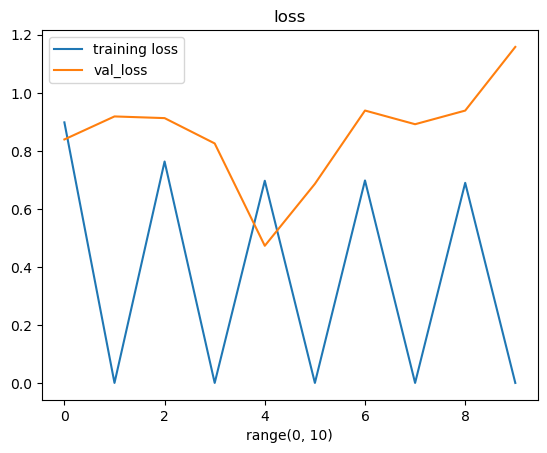

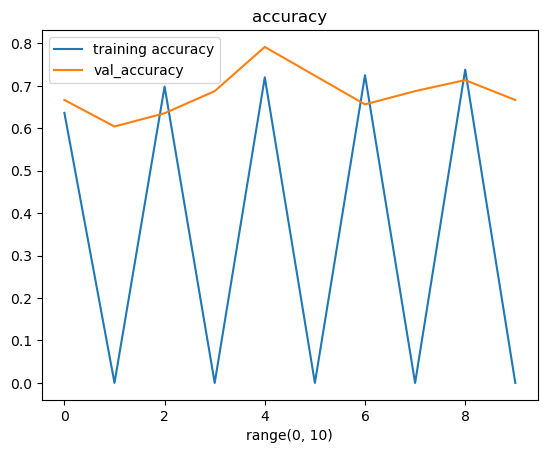

In [19]:

# plot the results

def plot_loss_curves(history):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]

    epochs = range(len(history.history["loss"]))

    # plot the loss
    plt.plot(epochs, loss, label = "training loss")
    plt.plot(epochs, val_loss, label="val_loss")
    plt.title("loss")
    plt.xlabel(epochs)
    plt.legend()
    plt.show()

      # plot the accuracy
    plt.plot(epochs, accuracy, label = "training accuracy")
    plt.plot(epochs, val_accuracy, label="val_accuracy")
    plt.title("accuracy")
    plt.xlabel(epochs)
    plt.legend()
    plt.show()

# run the function
plot_loss_curves(history)


